Basic boiler plate code don't run this tab

In [ ]:
# Open video file
cap = cv2.VideoCapture('/Users/suryanshpatel/Projects/Pose_detection/correct-squat-side-view.mp4')

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Convert the BGR image to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the image and detect the pose
    results = pose.process(image)

    # Convert the image back to BGR for rendering
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw the pose annotation on the image
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Display the image
    cv2.imshow('Pose Detection', image)

    if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()


trash plot

In [ ]:
def capture_joint_points(image, results):
    joint_points = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            joint_points.append((landmark.x, landmark.y))
    return joint_points

def plot_joint_points(all_joint_points):
    for i, points in enumerate(zip(*all_joint_points)):
        xs, ys = zip(*points)
        plt.figure()
        plt.plot(xs, ys, marker='o', linestyle='-')
        plt.title(f'Joint {i} Motion Over Time')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().invert_yaxis()
        plt.show()

all_joint_points = [] 

for frame in key_frames:
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)
    joint_points = capture_joint_points(frame, results)
    all_joint_points.append(joint_points)

# plot_joint_points(all_joint_points)

only displaying one frame may be vs code problems

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Function to animate the joint points
def animate_joint_points(all_joint_points):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)  # Invert y-axis to match image coordinates

    # Initialize plot
    scat = ax.scatter([], [], c='blue')

    def update(frame):
        joint_points = all_joint_points[frame]
        xs, ys = zip(*joint_points)
        scat.set_offsets(np.c_[xs, ys])
        ax.set_title(f'Frame {frame}')
        return scat,

    ani = animation.FuncAnimation(fig, update, frames=len(all_joint_points), blit=True, repeat=False)
    plt.show()

# Call the function to animate joint points
animate_joint_points(all_joint_points)

In [ ]:
# frames coodinated scaled
def plot_coordinates(coordinates, frame_number, save_folder):
    plt.figure()
    xs, ys = zip(*coordinates)
    plt.plot(xs, ys, marker='o', linestyle='-')
    plt.title(f'Joint Coordinates - Frame {frame_number}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.savefig(os.path.join(save_folder, f'coordinates_frame_{frame_number:03d}.png'))
    plt.close()

In [ ]:
# Open video file
input_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/correct-squat-side-view.mp4'
output_folder = '/Users/suryanshpatel/Projects/Pose_detection/annotated_frames'
coordinates_folder = '/Users/suryanshpatel/Projects/Pose_detection/coordinates'

# Create output folders if they don't exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(coordinates_folder, exist_ok=True)

# Initialize video capture
cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Initialize VideoWriter for annotated video
output_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/correct-squat-side-view-skeleton2.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Initialize variables for key frames
key_frames = []
prev_frame = None

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if prev_frame is None or is_key_frame(prev_frame, gray_frame):
        key_frames.append(frame)
        prev_frame = gray_frame

    # Process the image and detect the pose
    results = pose.process(rgb_frame)

    # Create a blank image (white background)
    blank_image = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 255

    # Draw the pose annotation on the blank image
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(blank_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Save annotated frame
        annotated_frame_path = os.path.join(output_folder, f'frame_{len(key_frames):03d}.png')
        cv2.imwrite(annotated_frame_path, cv2.cvtColor(blank_image, cv2.COLOR_RGB2BGR))

        # Optionally plot and save coordinates
        if results.pose_landmarks:
            joint_coordinates = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
            plot_coordinates(joint_coordinates, frame_number=len(key_frames), save_folder=coordinates_folder)

    # Write the frame to the output video
    out.write(blank_image)

# Release resources
cap.release()
out.release()
# cv2.destroyAllWindows()  # Uncomment if you are displaying the video

print(f'Output video saved as {output_video_path}')
print(f'Annotated frames saved in {output_folder}')
print(f'Coordinate plots saved in {coordinates_folder}')

below code is to save skeleton video

In [ ]:
# Open video file
input_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/incorrect-squat-side-view.mp4'#'/Users/suryanshpatel/Projects/Pose_detection/videos/correct-squat-side-view.mp4'
output_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/correct-squat-side-view-skeleton3.mp4'
key_frames = []
prev_frame = None
cap = cv2.VideoCapture(input_video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 files
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Convert the BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if prev_frame is None or is_key_frame(prev_frame, gray_frame):
        key_frames.append(frame)
        prev_frame = gray_frame

    # Process the image and detect the pose
    results = pose.process(rgb_frame)

    # Create a blank image (white background)
    blank_image = np.ones((frame_height, frame_width, 3), dtype=np.uint8) * 255

    # Draw the pose annotation on the blank image
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(blank_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Write the frame to the output video
    out.write(blank_image)

    # Optionally display the image (comment out if not needed)
    # cv2.imshow('Pose Detection', blank_image)
    # if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
    #     break

# Release resources
cap.release()
out.release()
# cv2.destroyAllWindows()  # Uncomment if you are displaying the video

print(f'Output video saved as {output_video_path}')

TO capture Video from webcam

In [ ]:
import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    cv2.imshow('Pose Detection', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


systematic video

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def initialize_video_capture(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    return cap, frame_width, frame_height, fps

def initialize_video_writer(output_video_path, frame_width, frame_height, fps):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    return out

def is_key_frame(prev_frame, current_frame):
    # Implement your logic to determine key frames
    return False  # Placeholder for demo

def annotate_frame(frame, results):
    blank_image = np.ones_like(frame) * 255  # White background
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(blank_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    return blank_image

def save_frame(frame, output_folder, frame_number):
    annotated_frame_path = os.path.join(output_folder, f'frame_{frame_number:03d}.png')
    cv2.imwrite(annotated_frame_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

def plot_coordinates(coordinates, frame_number, frame_width, frame_height, save_folder):
    plt.figure()
    scaled_coordinates = [(x * frame_width, y * frame_height) for x, y in coordinates]
    xs, ys = zip(*scaled_coordinates)
    plt.plot(xs, ys, marker='o', linestyle='-', color='b')
    plt.title(f'Joint Coordinates - Frame {frame_number}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlim(0, frame_width)
    plt.ylim(frame_height, 0)  # Invert y-axis limits
    plt.savefig(os.path.join(save_folder, f'coordinates_frame_{frame_number:03d}.png'))
    plt.close()

def process_video(input_video_path, output_folder, coordinates_folder, output_video_path):
    # Create output folders if they don't exist
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(coordinates_folder, exist_ok=True)

    # Initialize video capture
    cap, frame_width, frame_height, fps = initialize_video_capture(input_video_path)

    # Initialize VideoWriter for annotated video
    out = initialize_video_writer(output_video_path, frame_width, frame_height, fps)

    # Initialize variables for key frames
    key_frames = []
    prev_frame = None
    frame_number = 0

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is None or is_key_frame(prev_frame, gray_frame):
            key_frames.append(frame)
            prev_frame = gray_frame

        # Process the image and detect the pose
        results = pose.process(rgb_frame)

        # Annotate and save the frame
        annotated_frame = annotate_frame(frame, results)
        save_frame(annotated_frame, output_folder, frame_number)

        # Plot and save coordinates
        if results.pose_landmarks:
            joint_coordinates = [(lm.x, lm.y) for lm in results.pose_landmarks.landmark]
            plot_coordinates(joint_coordinates, frame_number, frame_width, frame_height, coordinates_folder)

        # Write the frame to the output video
        out.write(annotated_frame)

        frame_number += 1

    # Release resources
    cap.release()
    out.release()
    # cv2.destroyAllWindows()  # Uncomment if you are displaying the video

    print(f'Output video saved as {output_video_path}')
    print(f'Annotated frames saved in {output_folder}')
    print(f'Coordinate plots saved in {coordinates_folder}')

# Example usage
if __name__ == "__main__":
    input_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/incorrect-squat-side-view.mp4'
    output_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/annotated_frames/af5'
    coordinates_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/plots/co5'
    output_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/incorrect_5.mp4'
    process_video(input_video_path, output_folder, coordinates_folder, output_video_path)


to cut video on exercise

In [ ]:
import tensorflow as tf
def is_key_frame(prev_frame, current_frame, threshold=30):
    diff = cv2.absdiff(prev_frame, current_frame)
    non_zero_count = np.count_nonzero(diff)
    return non_zero_count > threshold

def is_exercising(pose_landmarks, model):
    # Convert pose landmarks to a format suitable for the model
    landmarks = np.array([[lm.x, lm.y, lm.z] for lm in pose_landmarks.landmark]).flatten()
    landmarks = landmarks.reshape(1, -1)  # Reshape for the model
    prediction = model.predict(landmarks)
    return prediction[0] == 1  # Assuming the model returns 1 for exercise and 0 for non-exercise

cap = cv2.VideoCapture(0)
prev_frame = None

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Load the pre-trained model (replace with your actual model loading code)
model = tf.keras.models.load_model('path_to_your_model.h5')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 30.0  # Assuming a frame rate of 30 FPS
frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

recording = False
video_writer = None
segment_count = 0

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is None or is_key_frame(prev_frame, gray_frame):
            results = pose.process(rgb_frame)
            if results.pose_landmarks and is_exercising(results.pose_landmarks, model):
                if not recording:
                    # Start a new video segment
                    recording = True
                    segment_count += 1
                    video_writer = cv2.VideoWriter(f'exercise_segment_{segment_count}.avi', fourcc, fps, frame_size)
                
                # Write the frame to the video file
                video_writer.write(frame)
            else:
                if recording:
                    # Stop recording the current video segment
                    recording = False
                    video_writer.release()
                    video_writer = None

            prev_frame = gray_frame

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        cv2.imshow('Key Frame Detection', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release the video writer if recording
if recording and video_writer is not None:
    video_writer.release()

cap.release()
cv2.destroyAllWindows()


code to detect multiple people and boxes

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Load YOLO model
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = net.getLayerNames()

# Adjust indexing to handle both cases where net.getUnconnectedOutLayers() returns a 1D or 2D array
try:
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Function to normalize joint points within bounding box
def normalize_joint_points_within_box(joint_points, box):
    x_min, y_min, width, height = box
    normalized_points = []
    for (x, y) in joint_points:
        norm_x = (x - x_min) / width
        norm_y = (y - y_min) / height
        normalized_points.append((norm_x, norm_y))
    return normalized_points

# Function to compare joint points
def compare_joint_points(user_points, professional_points):
    differences = []
    for user_point, professional_point in zip(user_points, professional_points):
        diff = np.linalg.norm(np.array(user_point) - np.array(professional_point))
        differences.append(diff)
    return differences

# Initialize MediaPipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

cap = cv2.VideoCapture(0)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

all_joint_points = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Get bounding box for the person
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if class_id == 0 and confidence > 0.5:  # Class 0 is for person
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = max(0, int(center_x - w / 2))
                y = max(0, int(center_y - h / 2))
                w = min(w, width - x)
                h = min(h, height - y)

                # Extract the region within the bounding box
                roi = frame[y:y+h, x:x+w]
                
                if roi.size == 0:  # Check if the ROI is empty
                    continue

                # Process the region with MediaPipe for pose estimation
                rgb_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                results = pose.process(rgb_frame)

                # Capture joint points
                joint_points = []
                if results.pose_landmarks:
                    for landmark in results.pose_landmarks.landmark:
                        joint_points.append((landmark.x * w + x, landmark.y * h + y))

                # Normalize joint points within bounding box
                normalized_points = normalize_joint_points_within_box(joint_points, (x, y, w, h))
                all_joint_points.append(normalized_points)

                # Draw the bounding box
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # Draw the pose annotation on the image
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(roi, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Optionally display the image
    cv2.imshow('Pose Detection', frame)
    if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

# Convert to NumPy array
all_joint_points = np.array(all_joint_points)

# Load professional's joint points (normalized) for comparison
professional_joint_points = np.load('professional_joint_points.npy')

# Compare user's joint points with professional's
differences = []
for user_points in all_joint_points:
    differences.append(compare_joint_points(user_points, professional_joint_points))

# Convert differences to NumPy array for easier processing
differences = np.array(differences)

# Plot the results
plt.figure(figsize=(10, 5))
for i, joint_diff in enumerate(differences.T):
    plt.plot(joint_diff, label=f'Joint {i+1}')
plt.xlabel('Frame')
plt.ylabel('Difference')
plt.title('Joint Differences between User and Professional')
plt.legend()
plt.show()


working code with yolo

In [ ]:
cap = cv2.VideoCapture(0)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

all_joint_points = []
best_box_dimensions = []

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 files
# output = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    height, width, channels = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Track the best detection
    best_confidence = 0
    best_box = None

    # Get bounding box for the person with the highest confidence
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if class_id == 0 and confidence > best_confidence:  # Class 0 is for person
                best_confidence = confidence
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = max(0, int(center_x - w / 2))
                y = max(0, int(center_y - h / 2))
                w = min(w, width - x)
                h = min(h, height - y)
                best_box = (x, y, w, h)

    if best_box:
        x, y, w, h = best_box

        # Extract the region within the bounding box
        roi = frame[y:y+h, x:x+w]

        if roi.size == 0:  # Check if the ROI is empty
            continue

        # Process the region with MediaPipe for pose estimation
        rgb_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_frame)

        # Capture joint points
        joint_points = []
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                joint_points.append((landmark.x * w + x, landmark.y * h + y))

        
        #Surya - don't want to normalize now store as it is as we are storing box dimentions as well
        #  Normalize joint points within bounding box
        # normalized_points = normalize_joint_points_within_box(joint_points, (x, y, w, h))
        # all_joint_points.append(normalized_points)
        
        
        all_joint_points.append(joint_points)
        best_box_dimensions.append((x, y, w, h))

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Draw the pose annotation on the image
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(roi, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Write the frame to the output video
    # output.write(frame)

    # Optionally display the image
    cv2.imshow('Pose Detection', frame)
    if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
        break

# Release resources
cap.release()
# output.release()
cv2.destroyAllWindows()

# Convert to NumPy array
all_joint_points = np.array(all_joint_points , dtype=object)
best_box_dimensions = np.array(best_box_dimensions)

print(all_joint_points.shape , best_box_dimensions.shape)

plots every joint points not adding arrows

In [ ]:

# Example function to extract data from all_frame_data
def extract_joint_data(all_frame_data):
    num_frames = all_frame_data.shape[0]
    num_joints = len(all_frame_data[0])  # Assuming all frames have the same number of joints
    
    # Initialize lists to store joint coordinates across frames
    joint_x = [[] for _ in range(num_joints)]
    joint_y = [[] for _ in range(num_joints)]
    
    # Iterate through each frame and each joint to extract coordinates
    for frame_idx in range(num_frames):
        frame = all_frame_data[frame_idx]
        for joint_idx in range(num_joints):
            landmark = frame[joint_idx]
            joint_x[joint_idx].append(landmark.get_x())  # Replace with actual method to get x coordinate
            joint_y[joint_idx].append(landmark.get_y())  # Replace with actual method to get y coordinate
    
    # Convert lists to NumPy arrays for plotting convenience
    joint_x = np.array(joint_x)
    joint_y = np.array(joint_y)
    
    return joint_x, joint_y

# Example usage
joint_x, joint_y = extract_joint_data(normalized_data)

# Plotting pair plot for all joints
num_joints = joint_x.shape[0]
plt.figure(figsize=(15, 15))
for i in range(num_joints):
    plt.subplot(6, 6, i + 1)
    sns.scatterplot(x=joint_x[i], y=joint_y[i], marker='o', s=10)
    plt.title(f'Joint {i + 1}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
plt.tight_layout()
plt.show()


frames animation for 2 exercises not working

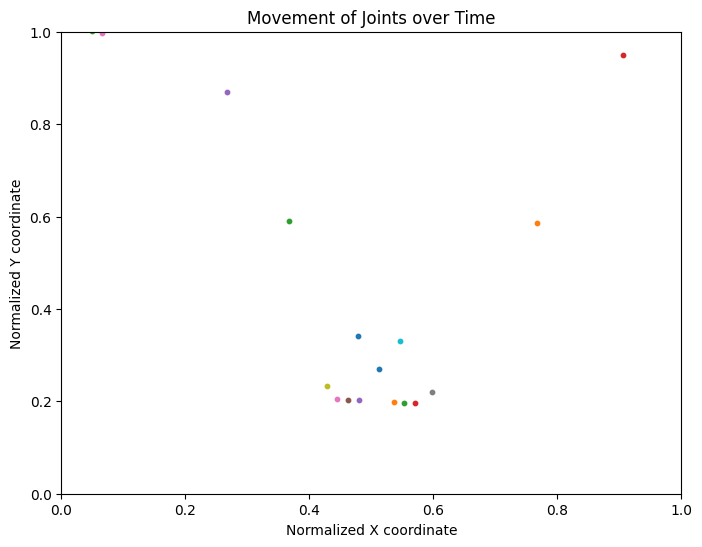

In [ ]:


# Function to prepare data for animation
def prepare_data_for_animation(normalized_data):
    num_frames = normalized_data.shape[0]
    num_joints = len(normalized_data[0])  # Assuming all frames have the same number of joints
    
    # Initialize lists to store normalized joint coordinates across frames
    joint_x_normalized = [[] for _ in range(num_joints)]
    joint_y_normalized = [[] for _ in range(num_joints)]
    
    # Iterate through each frame and each joint to extract normalized coordinates
    for frame_idx in range(num_frames):
        frame = normalized_data[frame_idx]
        for joint_idx in range(num_joints):
            landmark = frame[joint_idx]
            norm_x = landmark.get_x()  # Replace with actual method to get normalized x coordinate
            norm_y = landmark.get_y()  # Replace with actual method to get normalized y coordinate
            joint_x_normalized[joint_idx].append(norm_x)
            joint_y_normalized[joint_idx].append(norm_y)
    
    # Convert lists to NumPy arrays for plotting convenience
    joint_x_normalized = np.array(joint_x_normalized)
    joint_y_normalized = np.array(joint_y_normalized)
    
    return joint_x_normalized, joint_y_normalized

# Example function to update frames in animation
def update_frame(frame_idx, data, scatters):
    for i in range(len(scatters)):
        scatters[i].set_offsets(np.c_[data[0][i][frame_idx], data[1][i][frame_idx]])
    return scatters

# Example usage with normalized data
joint_x_normalized, joint_y_normalized = prepare_data_for_animation(normalized_data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize scatter plot with empty data
scatters = [ax.scatter([], [], s=10) for _ in range(len(joint_x_normalized))]

# Set axis limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Normalized X coordinate')
ax.set_ylabel('Normalized Y coordinate')

# Animation function
ani = animation.FuncAnimation(fig, update_frame, frames=len(joint_x_normalized[0]), fargs=((joint_x_normalized, joint_y_normalized), scatters), interval=50, blit=True)

plt.title('Movement of Joints over Time')
plt.show()


The graph will be upside down because matplot lib starts drawing graph form bottom left

In [ ]:
def draw_graph(graph, title="Graph Visualization"):
    pos = nx.get_node_attributes(graph, 'pos')
    plt.figure(figsize=(10, 10))
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray', font_size=10, font_color='black')
    plt.title(title)
    plt.show()

# Example function to visualize multiple graphs (e.g., from a sequence of frames)
def visualize_graph_sequence(graphs, start=0, end=10):
    for i in range(start, end):
        draw_graph(graphs[i], title=f"Graph at Frame {i}")

# Example usage to visualize a single graph
draw_graph(graphs_video1[0], title="Graph at Frame 0 (Video 1)")

# Example usage to visualize a sequence of graphs
# visualize_graph_sequence(graphs_video1, start=0, end=5)

Try to classify exercise    

In [ ]:
import torch
import torch.nn.functional as F

class_labels = {
    0: 'jumping_jacks',
    1: 'pushups',
    2: 'squats',
    # Add more classes as needed
}

def postprocess(outputs, threshold=0.5, window_size=5):
    # Step 1: Apply softmax to get probabilities
    probabilities = F.softmax(outputs, dim=1)
    
    # Step 2: Thresholding (if needed)
    if threshold is not None:
        probabilities = probabilities > threshold
    
    # Step 3: Smoothing (if needed)
    if window_size is not None and window_size > 1:
        smoothed_predictions = []
        for i in range(len(probabilities) - window_size + 1):
            window = probabilities[i:i+window_size]
            majority_vote = torch.mode(window, dim=0).values
            smoothed_predictions.append(majority_vote)
        probabilities = torch.tensor(smoothed_predictions)
    
    # Map to class labels
    _, predicted_indices = torch.max(probabilities, 1)
    predicted_labels = [class_labels[idx.item()] for idx in predicted_indices]
    
    return predicted_labels


In [ ]:
import torch
from pytorchvideo.models.hub import slow_r50

# Load a pre-trained SlowFast model from PyTorchVideo
model = slow_r50(pretrained=True)
model.eval()

# Prepare your data as needed
# You will need to preprocess your keypoints and frames appropriately

def classify_exercise(frames):
    # Preprocess frames to the required input format for the model
    # Placeholder preprocessing

    
    with torch.no_grad():
        outputs = model(frames)
    
    # Post-process outputs to get class predictions
    predicted_classes = postprocess(outputs)
    
    return predicted_classes


print(classify_exercise(coordinates_video1))

Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth" to /Users/suryanshpatel/.cache/torch/hub/checkpoints/SLOW_8x8_R50.pyth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>